# Ethics and Bias in Data Science - Mitigation (Part - II)

In this blog post, we will discuss the tools at the disposal of Data Scientists to **mitigate the bias** and improve the fairness of analysis and models.

We will use **Fairlearn** package for our understanding. Fairlearn python package comprises algorithms for mitigating and metrics for evaluating bias of a dataset or model. It is essential to learn a few key concepts about fairness which will help us when we dive into the code.

First things first - what is fairness?

It is difficult to define fairness. There are atleat **21 mathematical definitions of fairness.** For the sake of this article, the term fairness means, “impartial and just treatment or behaviour without favouritism or discrimination to any individual or group”. The meaning of fairness will also change according the challenge at hand and the context.  We should chose a definition for fairness in consultation with all the stakeholders after deliberating the impact for the company and the society.

### Important terms 

**Protected Attribute**  &nbsp; An attribute or variable which divides the population into groups whose outcomes should be equal. Examples are attributes like gender, race, caste, age, etc.

**Privileged Protected Attribute** &nbsp;  The value of the protected attribute belonging to a group which benefitted historically with a systemic advantage. If males get loans easily when compared to females, then they are Privileged Protected Attribute.

**Favourable label** &nbsp;  The value of a label for an instance favourable for the recipient. Loan approved is a favourable label. 

**Unfavourable label** &nbsp;  This is the opposite of favourable label. Loan getting rejected is an unfavourable label.

**Fairness Metric**  &nbsp; This is the quantification of bias in the data or model. A metric which quantifies how much a male is at an advantage when compared to a female is an example of fairness metric.

**Individual Vs Group Fairness** &nbsp; Individual fairness means similar individuals treated similarly. Example, in college admissions, females treated separately from males according to their EMCET scores.Group fairness is partitioning the population into distinct groups and checking if the statistical measures are equal for all the groups. 

**We’re all equal (WAE) Vs What you see is what you get (WYSIWYG)** &nbsp;  These two are different philosophies for the group fairness.According to WAE philosophy, the observations do not inform about the capability of the group because of structural bias. Example, EMCET scores are not an accurate indicator of the success in college for males and females. There are structural biases present because of which the EMCET scores are not an indicator of success.WYSIWYG believes the observations reflect true capabilities. Example, EMCET scores are an indicator of success in college. Metrics for WAE and WYSIWYG world views are different.  Chose a suitable metric depending on the worldview of data scientists and different stakeholders for the project and the problem being tackled.

**Mitigation algorithms**   &nbsp;  The mitigation algorithms are of three types. Pre-processing, in-processing and post-processing depending on the machine learning life stage at which we use them. There are pre-processing algorithms which will either change the feature or label to de-bias the data. Some pre-processing algorithms assign weights to the instances without changing the features or labels. Algorithms need selection according to the requirement. In-processing algorithms play with the hyper-parameters like regularization to produce de-biased results. Post-processing algorithms change the final outputs to produce fair results.

Now let us turn our attention to a toy example to see how this works in action. The dataset for this exercise is ‘Loan Prediction’ data provided by Analytics Vidhya for practice. 
According to their website, The Dream Housing Finance company wishes to automate the loan eligibility process. The company captures historical data like Gender, Married, Dependents, Education, self-employed, LoanAmount etc of the past customers along with Loan_status i.e. if the loan is approved or not. The aim is to look at patterns in the data and decide if the company should provide loan to the customer or not.

The variables in the dataset are:-
![Data_dictionary](images/data_dictionary.png)
(credit: Analytics Vidhya)

Let us see with a toy machine learning algorithm, what will happen if we are not mitigating the bias and what are the results if bias is mitigated.
Let’s dive in..

![loan applicants](images/gender_applicants.png)

In [5]:
# peek at the data
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y


In [6]:
# See the shape of the data
data.shape

(480, 13)

In [7]:
# Drop the Loan_Id which is not required for analysis
data.drop([ 'Loan_ID'],axis = 1, inplace = True)

In [8]:
# Change the data type for credit_history
data ['Credit_History'] = data ['Credit_History'].astype('category')

In [9]:
# create a new column target as Fairlearn expects numeric value for target
# 1 indicated loan approved, 0 indicates loan was rejected
data['target'] = np.where(data['Loan_Status'] == 'Y', 1, 0)

In [10]:
# create independent and dependent variables
X = data
y_true = X['target']

In [11]:
# Drop the unnecessary columns from the data
X = data.drop(columns = [ 'Loan_Status','target'],axis = 1)

In [12]:
# Create dummy variables for the categorical data
X = pd.get_dummies(X)

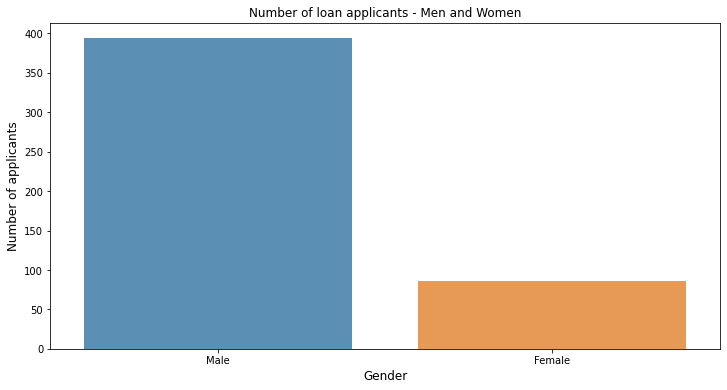

In [13]:
# Plot the number of male and female loan applicants
gender  = data['Gender'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(gender.index, gender.values, alpha=0.8)
plt.title('Number of loan applicants - Men and Women')
plt.ylabel('Number of applicants', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.show()

In [14]:
# Protected variable
gender = data.Gender

In [15]:
# see how logistic regression performs on the data before mitigation
clf = LogisticRegression(penalty='l2', class_weight = 'balanced',random_state = 786)
clf.fit(X,y_true)
LogisticRegression()
y_pred = clf.predict(X)

In [16]:
# check the accuracy of the algorithm on the protected variable
group_summary(accuracy_score,y_true,y_pred,sensitive_features = gender)
# There is a big difference in accuracy for males and females

{'overall': 0.7395833333333334,
 'by_group': {'Female': 0.5813953488372093, 'Male': 0.7741116751269036}}

### As shown on the dashboard, the disparity in Recall performance for both the groups is 34.9%. The disparity in predictions is more than 30%

In [17]:
# create a dashboard for visualization
# As this is a imbalanced dataset, let us check how the algorithm is performing on Recall
from fairlearn.widget import FairlearnDashboard
FairlearnDashboard(sensitive_features = gender,
                   sensitive_feature_names=['sex'],
                   y_true = y_true,
                   y_pred = y_pred)

FairlearnWidget(value={'true_y': [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1…

In [18]:
# Let us use a algorithm for mitigation. This algorithm will take into account the constraint while optimizing the cost function
from fairlearn.reductions import ExponentiatedGradient , DemographicParity
np.random.seed(786)
constraint = DemographicParity()
clf =LogisticRegression(penalty='l2', class_weight = 'balanced',random_state = 786)
mitigator = ExponentiatedGradient(clf, constraint)
mitigator.fit(X, y_true, sensitive_features = gender)
y_pred_mitigated = mitigator.predict(X)

In [19]:
# Lets check how the algorithm performs after mitigation on overall level and for both groups
from fairlearn.metrics import selection_rate_group_summary
selection_rate_group_summary(y_true, y_pred_mitigated, sensitive_features = gender)
# There is a slight dip in accuracy but the disparity in accuracy between both the groups reduced from 19% to less than 1%

{'overall': 0.7229166666666667,
 'by_group': {'Female': 0.7209302325581395, 'Male': 0.7233502538071066}}

In [20]:
# Lets check the performance on Recall with the mitigated algorithm
FairlearnDashboard(sensitive_features = gender,
                  sensitive_feature_names = ['sex'],
                  y_true = y_true,
                  y_pred = {"initial model": y_pred, "mitigated model" : y_pred_mitigated})

# The Recall for the mitigated algorithm is 86.1% compared to 79.2% for the inital algorithm
# The disparity reduced from more than 34% to 1.15%
# A win-win situation for any data scientist. This is a toy example and in a real life scenario the recall of the mitigated algorithm 
# may reduce while reducing disparity.

FairlearnWidget(value={'true_y': [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1…